In [184]:
# coding=utf-8

import numpy as np
import pandas as pd

from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata


# region Auxiliary functions
def ts_sum(df, window=10):
    """
    Wrapper function to estimate rolling sum.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).sum()


def sma(df, window=10):
    """
    Wrapper function to estimate SMA.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).mean()


def stddev(df, window=10):
    """
    Wrapper function to estimate rolling standard deviation.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).std()


def correlation(x, y, window=10):
    """
    Wrapper function to estimate rolling corelations.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).corr(y)


def covariance(x, y, window=10):
    """
    Wrapper function to estimate rolling covariance.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).cov(y)


def rolling_rank(na):
    """
    Auxiliary function to be used in pd.rolling_apply
    :param na: numpy array.
    :return: The rank of the last value in the array.
    """
    return rankdata(na)[-1]


def ts_rank(df, window=10):
    """
    Wrapper function to estimate rolling rank.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series rank over the past window days.
    """
    return df.rolling(window).apply(rolling_rank)


def rolling_prod(na):
    """
    Auxiliary function to be used in pd.rolling_apply
    :param na: numpy array.
    :return: The product of the values in the array.
    """
    return np.prod(na)


def product(df, window=10):
    """
    Wrapper function to estimate rolling product.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series product over the past 'window' days.
    """
    return df.rolling(window).apply(rolling_prod)


def ts_min(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).min()


def ts_max(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series max over the past 'window' days.
    """
    return df.rolling(window).max()


def delta(df, period=1):
    """
    Wrapper function to estimate difference.
    :param df: a pandas DataFrame.
    :param period: the difference grade.
    :return: a pandas DataFrame with today’s value minus the value 'period' days ago.
    """
    return df.diff(period)


def delay(df, period=1):
    """
    Wrapper function to estimate lag.
    :param df: a pandas DataFrame.
    :param period: the lag grade.
    :return: a pandas DataFrame with lagged time series
    """
    return df.shift(period)


def rank(df):
    """
    Cross sectional rank
    :param df: a pandas DataFrame.
    :return: a pandas DataFrame with rank along columns.
    """
    return df.rank(axis=1, pct=True)


def scale(df, k=1):
    """
    Scaling time serie.
    :param df: a pandas DataFrame.
    :param k: scaling factor.
    :return: a pandas DataFrame rescaled df such that sum(abs(df)) = k
    """
    return df.mul(k).div(np.abs(df).sum())


def ts_argmax(df, window=10):
    """
    Wrapper function to estimate which day ts_max(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmax) + 1 


def ts_argmin(df, window=10):
    """
    Wrapper function to estimate which day ts_min(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmin) + 1


def decay_linear(df, period=10):
    """
    Linear weighted moving average implementation.
    :param df: a pandas DataFrame.
    :param period: the LWMA period
    :return: a pandas DataFrame with the LWMA.
    """
    # Clean data
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(value=0, inplace=True)

    na_lwma = np.zeros_like(df)
    na_lwma[:period, :] = df.ix[:period, :]
    na_series = df.as_matrix()

    divisor = period * (period + 1) / 2
    y = (np.arange(period) + 1) * 1.0 / divisor
    # Estimate the actual lwma with the actual close.
    # The backtest engine should assure to be snooping bias free.
    for row in range(period - 1, df.shape[0]):
        x = na_series[row - period + 1: row + 1, :]
        na_lwma[row, :] = (np.dot(x.T, y))
    return pd.DataFrame(na_lwma, index=df.index, columns=df.columns)


# endregion

"""
t=[a for a in dir(aa) if a.startswith('alpha')] crea una lista con los nombres de los metodos
getattr(aa, t[2])() llama el metodo.
"""


class Alphas(object):
    def __init__(self, pn_data):
        """
        :type pn_data: pandas.Panel
        """
        #self.open = pn_data.minor_xs('open')
        #self.high = pn_data.minor_xs('high')
        #self.low = pn_data.minor_xs('low')
        #self.close = pn_data.minor_xs('close')
        #self.volume = pn_data.minor_xs('volume')
        
        self.open = pn_data['open_price']
        self.high = pn_data['high']
        self.low = pn_data['low']
        self.close = pn_data['close_price']
        self.volume = pn_data['volume']
        self.returns = self.close.pct_change()
        
    
    def alpha001(self):
        inner = self.close
        inner[self.returns < 0] = stddev(self.returns, 20)
        return rank(ts_argmax(inner ** 2, 5))

    def alpha002(self):
        df = -1 * correlation(rank(delta(log(self.volume), 2)), rank((self.close - self.open) / self.open), 6)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)

    def alpha003(self):
        df = -1 * correlation(rank(self.open), rank(self.volume), 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)

    def alpha004(self):
        return -1 * ts_rank(rank(self.low), 9)

    def alpha006(self):
        df = -1 * correlation(self.open, self.volume, 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)

    def alpha007(self):
        adv20 = sma(self.volume, 20)
        alpha = -1 * ts_rank(abs(delta(self.close, 7)), 60) * sign(delta(self.close, 7))
        alpha[adv20 >= self.volume] = -1
        return alpha

    def alpha008(self):
        return -1 * (rank(((ts_sum(self.open, 5) * ts_sum(self.returns, 5)) -
                           delay((ts_sum(self.open, 5) * ts_sum(self.returns, 5)), 10))))

    def alpha009(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 5) > 0
        cond_2 = ts_max(delta_close, 5) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha

    def alpha010(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 4) > 0
        cond_2 = ts_max(delta_close, 4) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha

    def alpha012(self):
        return sign(delta(self.volume, 1)) * (-1 * delta(self.close, 1))

    def alpha013(self):
        return -1 * rank(covariance(rank(self.close), rank(self.volume), 5))

    def alpha014(self):
        df = correlation(self.open, self.volume, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * rank(delta(self.returns, 3)) * df

    def alpha015(self):
        df = correlation(rank(self.high), rank(self.volume), 3)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_sum(rank(df), 3)

    def alpha016(self):
        return -1 * rank(covariance(rank(self.high), rank(self.volume), 5))

    def alpha017(self):
        adv20 = sma(self.volume, 20)
        return -1 * (rank(ts_rank(self.close, 10)) *
                     rank(delta(delta(self.close, 1), 1)) *
                     rank(ts_rank((self.volume / adv20), 5)))

    def alpha018(self):
        df = correlation(self.close, self.open, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank((stddev(abs((self.close - self.open)), 5) + (self.close - self.open)) +
                          df))

    def alpha019(self):
        return ((-1 * sign((self.close - delay(self.close, 7)) + delta(self.close, 7))) *
                (1 + rank(1 + ts_sum(self.returns, 250))))

    def alpha020(self):
        return -1 * (rank(self.open - delay(self.high, 1)) *
                     rank(self.open - delay(self.close, 1)) *
                     rank(self.open - delay(self.low, 1)))

    def alpha021(self):
        cond_1 = sma(self.close, 8) + stddev(self.close, 8) < sma(self.close, 2)
        cond_2 = sma(self.volume, 20) / self.volume < 1
        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index,
                             columns=self.close.columns)
        alpha[cond_1 | cond_2] = -1
        return alpha

    def alpha022(self):
        df = correlation(self.high, self.volume, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * delta(df, 5) * rank(stddev(self.close, 20))

    def alpha023(self):
        cond = sma(self.high, 20) < self.high
        alpha = pd.DataFrame(np.zeros_like(self.close), index=self.close.index,
                             columns=self.close.columns)
        alpha[cond] = -1 * delta(self.high, 2)
        return alpha

    def alpha024(self):
        cond = delta(sma(self.close, 100), 100) / delay(self.close, 100) <= 0.05
        alpha = -1 * delta(self.close, 3)
        alpha[cond] = -1 * (self.close - ts_min(self.close, 100))
        return alpha

    def alpha026(self):
        df = correlation(ts_rank(self.volume, 5), ts_rank(self.high, 5), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_max(df, 3)

    def alpha028(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return scale(((df + ((self.high + self.low) / 2)) - self.close))

    def alpha029(self):
        return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-1 * rank(delta((self.close - 1), 5)))), 2))))), 5) +
                ts_rank(delay((-1 * self.returns), 6), 5))

    def alpha030(self):
        delta_close = delta(self.close, 1)
        inner = sign(delta_close) + sign(delay(delta_close, 1)) + sign(delay(delta_close, 2))
        return ((1.0 - rank(inner)) * ts_sum(self.volume, 5)) / ts_sum(self.volume, 20)

    def alpha031(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 12)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return ((rank(rank(rank(decay_linear((-1 * rank(rank(delta(self.close, 10)))), 10)))) +
                 rank((-1 * delta(self.close, 3)))) + sign(scale(df)))

    def alpha033(self):
        return rank(-1 + (self.open / self.close))

    def alpha034(self):
        inner = stddev(self.returns, 2) / stddev(self.returns, 5)
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return rank(2 - rank(inner) - rank(delta(self.close, 1)))

    def alpha035(self):
        return ((ts_rank(self.volume, 32) *
                 (1 - ts_rank(self.close + self.high - self.low, 16))) *
                (1 - ts_rank(self.returns, 32)))

    def alpha037(self):
        return rank(correlation(delay(self.open - self.close, 1), self.close, 200)) + rank(self.open - self.close)

    def alpha038(self):
        inner = self.close / self.open
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return -1 * rank(ts_rank(self.open, 10)) * rank(inner)

    def alpha039(self):
        adv20 = sma(self.volume, 20)
        return ((-1 * rank(delta(self.close, 7) * (1 - rank(decay_linear(self.volume / adv20, 9))))) *
                (1 + rank(ts_sum(self.returns, 250))))

    def alpha040(self):
        return -1 * rank(stddev(self.high, 10)) * correlation(self.high, self.volume, 10)

    def alpha043(self):
        adv20 = sma(self.volume, 20)
        return ts_rank(self.volume / adv20, 20) * ts_rank((-1 * delta(self.close, 7)), 8)

    def alpha044(self):
        df = correlation(self.high, rank(self.volume), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * df

    def alpha045(self):
        df = correlation(self.close, self.volume, 2)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank(sma(delay(self.close, 5), 20)) * df *
                     rank(correlation(ts_sum(self.close, 5), ts_sum(self.close, 20), 2)))

    def alpha046(self):
        inner = ((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10)
        alpha = (-1 * delta(self.close))
        alpha[inner < 0] = 1
        alpha[inner > 0.25] = -1
        return alpha

    def alpha049(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.1] = 1
        return alpha

    def alpha051(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.05] = 1
        return alpha

    def alpha052(self):
        return (((-1 * delta(ts_min(self.low, 5), 5)) *
                 rank(((ts_sum(self.returns, 240) - ts_sum(self.returns, 20)) / 220))) * ts_rank(self.volume, 5))

    def alpha053(self):
        inner = (self.close - self.low).replace(0, 0.0001)
        return -1 * delta((((self.close - self.low) - (self.high - self.close)) / inner), 9)

    def alpha054(self):
        inner = (self.low - self.high).replace(0, -0.0001)
        return -1 * (self.low - self.close) * (self.open ** 5) / (inner * (self.close ** 5))

    def alpha055(self):
        divisor = (ts_max(self.high, 12) - ts_min(self.low, 12)).replace(0, 0.0001)
        inner = (self.close - ts_min(self.low, 12)) / (divisor)
        df = correlation(rank(inner), rank(self.volume), 6)
        return -1 * df.replace([-np.inf, np.inf], 0).fillna(value=0)

    def alpha060(self):
        divisor = (self.high - self.low).replace(0, 0.0001)
        inner = ((self.close - self.low) - (self.high - self.close)) * self.volume / divisor
        return - ((2 * scale(rank(inner))) - scale(rank(ts_argmax(self.close, 10))))
    
    def alpha_test(self):
        return self.close

In [185]:
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import SimpleMovingAverage,AverageDollarVolume
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import Q1500US
import numpy as np

In [186]:
pipe = Pipeline()
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
asset_list = res.index.levels[1].unique()[2:200]

In [187]:
prices = get_pricing(asset_list, start_date='2016-01-01', end_date='2017-01-01', fields=['open_price','high','low','close_price',
                                                                                        'volume'])

In [188]:
alpha_generator = Alphas(prices)

In [236]:
my_factor = alpha_generator.alpha_test().rank()
#my_factor = alpha_generator.alpha021().rank()
my_factor = my_factor.stack()
my_factor.ffill().bfill().fillna(0)

2016-01-04 00:00:00+00:00  Equity(24 [AAPL])        168.0
                           Equity(31 [ABAX])        235.0
                           Equity(39 [DDC])         189.0
                           Equity(41 [ARCB])        193.0
                           Equity(52 [ABM])         101.0
                           Equity(53 [ABMD])        123.0
                           Equity(62 [ABT])         206.0
                           Equity(64 [ABX])         110.0
                           Equity(66 [AB])          158.0
                           Equity(67 [ADSK])        182.0
                           Equity(69 [ACAT])        196.5
                           Equity(70 [VBF])         102.0
                           Equity(76 [TAP])         141.0
                           Equity(84 [ACET])        226.0
                           Equity(86 [ACG])          23.0
                           Equity(88 [ACI])           2.0
                           Equity(100 [IEP])        215.0
              

In [239]:
import alphalens as al

pr = get_pricing(asset_list, start_date='2015-12-01', end_date='2017-02-01', fields='price')
factor_data = al.utils.get_clean_factor_and_forward_returns(my_factor,
                                                                   pr,
                                                                   quantiles=5,
                                                                   #groupby=sectors,
                                                                   #groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                                   periods=(1,))

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,137.0,34.971561,28.409521,9037,20.549378
2,4.0,188.0,79.537688,38.926635,8756,19.910408
3,17.0,232.0,118.399027,44.280800,8740,19.874025
4,32.0,238.0,157.301110,42.570752,8741,19.876299
5,72.0,247.0,202.069114,33.260968,8703,19.789890


Returns Analysis


,1
Ann. alpha,-0.293
beta,0.109
Mean Period Wise Return Top Quantile (bps),-26.474
Mean Period Wise Return Bottom Quantile (bps),4.642
Mean Period Wise Spread (bps),-33.734


Information Analysis


,1
IC Mean,-0.066
IC Std.,0.125
t-stat(IC),-8.427
p-value(IC),0.000
IC Skew,-0.121
IC Kurtosis,0.704
Ann. IR,-8.427


Turnover Analysis


,1
Quantile 1 Mean Turnover,0.666
Quantile 2 Mean Turnover,0.738
Quantile 3 Mean Turnover,0.716
Quantile 4 Mean Turnover,0.728
Quantile 5 Mean Turnover,0.606


,1
Mean Factor Rank Autocorrelation,0.202


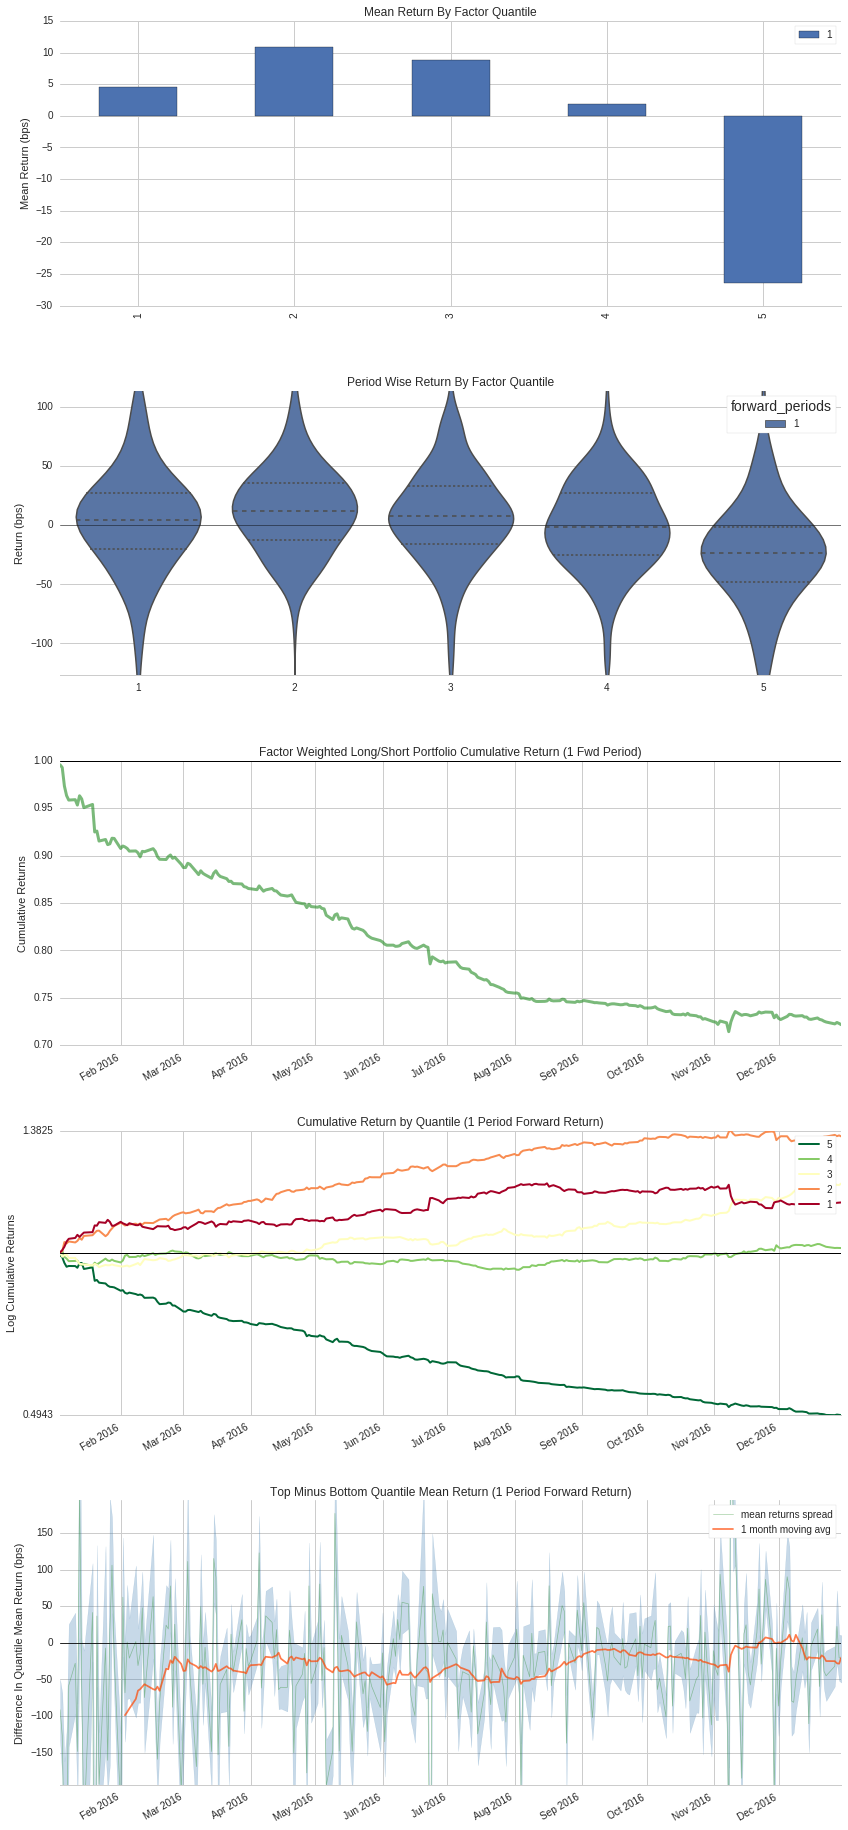

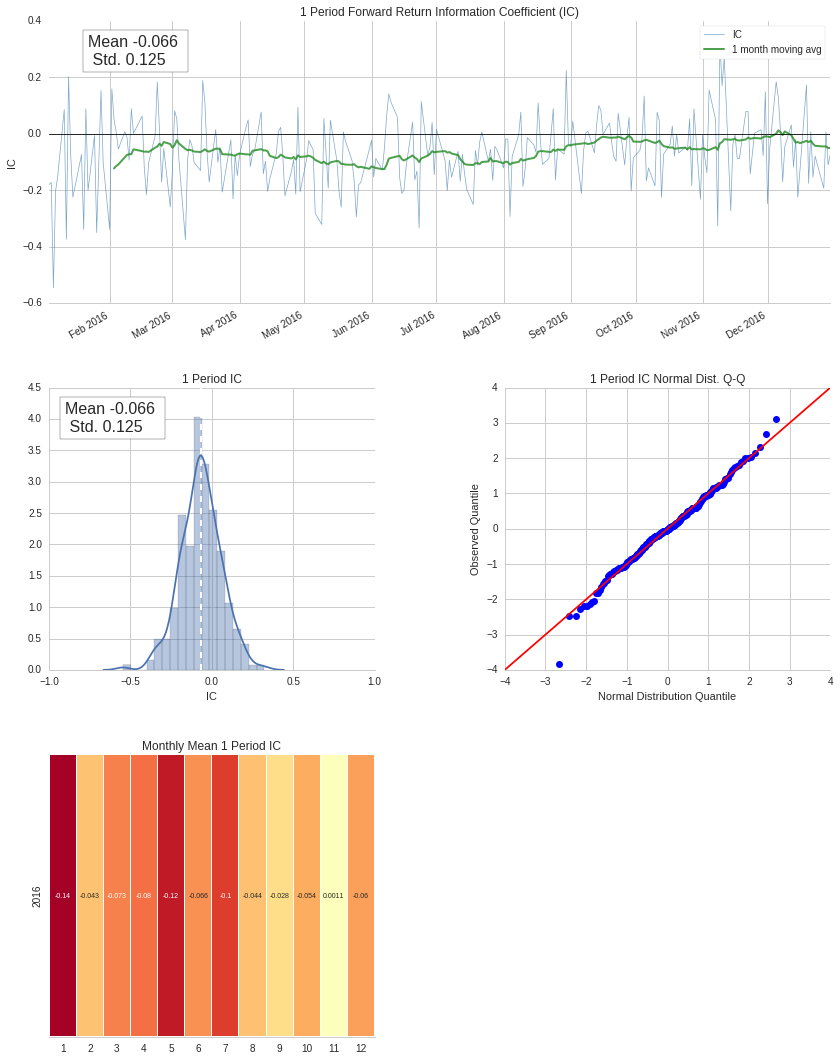

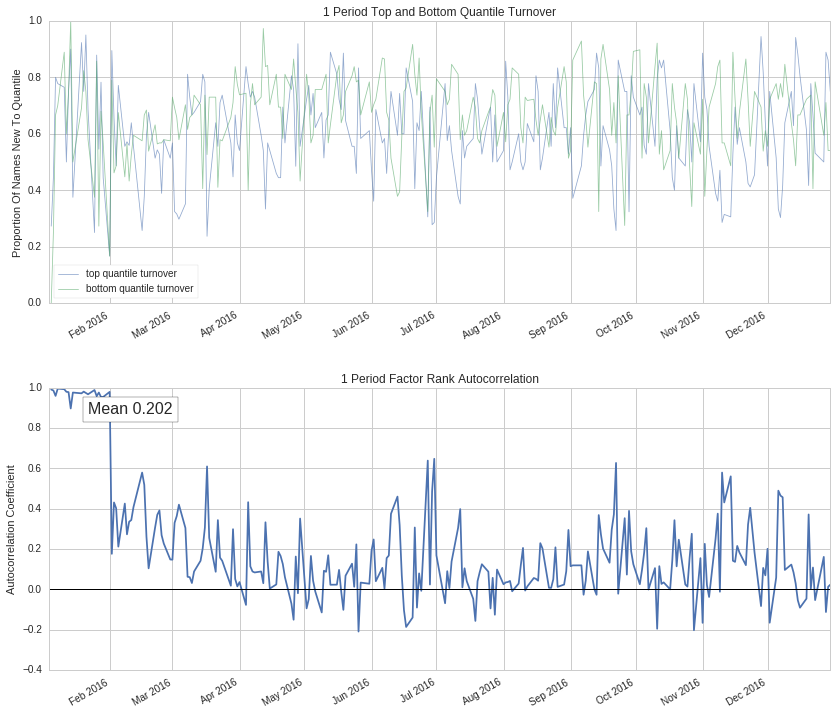

In [240]:
al.tears.create_full_tear_sheet(factor_data)